/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:234: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['a', 'b', 'c', 'd'])
/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['e', 'f', 'g', 'h'])


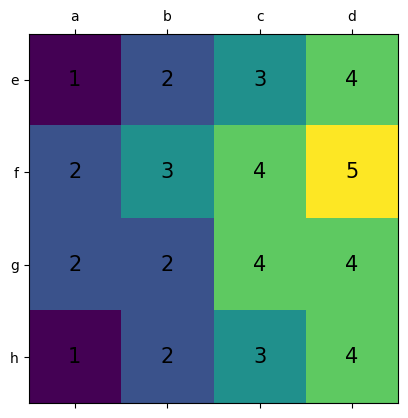

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:252: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['insert', 'fairness', 'notions', 'here'])
/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:253: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['No Missing', 'MCAR', 'MAR', 'NMAR'])


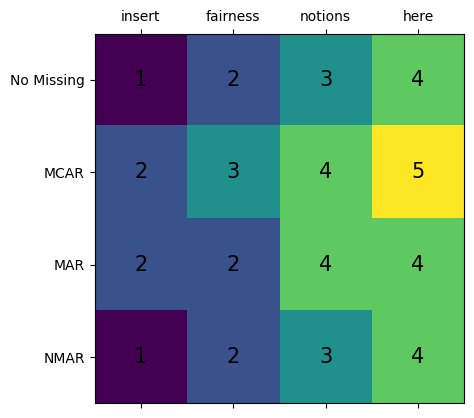

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


In [1]:
import pandas as pd
import os
import sys
from src.cleaning import datacleaning
from src import data_generation
from src.preparation import model_perform
import pandas as pd
import numpy as np
import aif360
from sklearn.model_selection import train_test_split
from aif360.sklearn.metrics import statistical_parity_difference
from aif360.sklearn.metrics import average_odds_difference
from aif360.sklearn.metrics import equal_opportunity_difference

In [2]:
data = datacleaning.cleaning(os.path.join(os.path.dirname(
    os.path.realpath('run.py')) + '/data/allegations_raw.csv'))

In [3]:
target = sys.argv[1]

if target == "test":
    data = datacleaning.cleaning(os.path.join(os.path.dirname(
        os.path.realpath('run.py')) + '/data/test.csv'))

if target == "all":
    data = datacleaning.cleaning(os.path.join(os.path.dirname(
        os.path.realpath('run.py')) + '/data/allegations_raw.csv'))

In [4]:
data.isna().sum()

complaint_id                   0
complainant_ethnicity       5505
complainant_gender          4195
complainant_age_incident    4829
allegation                     1
contact_reason               199
substantiated                  0
dtype: int64

In [5]:
data.head()

,complaint_id,complainant_ethnicity,complainant_gender,complainant_age_incident,allegation,contact_reason,substantiated
0,42835,Black,Female,38.0,Failure to provide RTKA card,Report-domestic dispute,True
1,24601,Black,Male,26.0,Action,Moving violation,True
2,24601,Black,Male,26.0,Race,Moving violation,True
3,26146,Black,Male,45.0,Question,PD suspected C/V of violation/crime - street,True
4,40253,NaN,NaN,16.0,Physical force,Report-dispute,True


In [6]:
train, test = train_test_split(data, train_size=0.8)

## Missingness Creation

We want the attribute with missingness to have around the same proportion of missingness for each type. This is because we don't want the amount of missingness to be a confounding factor in our results.

In [7]:
t = train.copy()
mcar = data_generation.mcar(t, 'substantiated')

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column].iloc[i] = np.nan


In [8]:
mcar['substantiated'].isna().sum() / mcar.shape[0]

0.20426440830397963

In [9]:
mcar = mcar.dropna(subset = 'substantiated')

In [10]:
t = train.copy()
mar = data_generation.mar(t, 'substantiated', 'complainant_ethnicity', 0.3)

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[miss_column].iloc[i] = np.nan


In [11]:
mar['substantiated'].isna().sum() / mar.shape[0]

0.15255189987259238

In [12]:
mar = mar.dropna(subset = 'substantiated')

In [13]:
t = train.copy()
nmar = data_generation.nmar(t, 'substantiated', 0.3)

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column].iloc[i] = np.nan


In [14]:
nmar['substantiated'].isna().sum() / nmar.shape[0]

0.16742861425466538

In [15]:
nmar = nmar.dropna(subset = 'substantiated')

Now we will "handle" the missingness by dropping missing values.

## Applying Fairness Notions


In [16]:
cat = ["complainant_ethnicity", "complainant_gender", "complainant_age_incident", "allegation", "contact_reason"]

### Calculating fairnes notions for No Missingness At All

In [17]:
#storing fairness notions for no missingness
no_missing_fairness = []
no_missing = model_perform.model(train, test, cat)
no_missing_fairness.append(no_missing)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Fairness notions for NMAR

In [ ]:
train_nmar, test_nmar = train_test_split(nmar, test_size=0.2)

In [ ]:
nmar_fairness = []
nmar_model = model_perform.model_missing(train_nmar, test_nmar, cat)
nmar_fairness.append(nmar_model)

### Fairness notions for MCAR

In [ ]:
train_mcar, test_mcar = train_test_split(mcar, test_size=0.2)


In [ ]:
mcar_fairness = []
mcar_model = model_perform.model_missing(train_mcar, test_mcar, cat)
mcar_fairness.append(mcar_model)

### Fairness notions for MAR

In [ ]:
train_mar, test_mar = train_test_split(mar, test_size=0.2)


In [ ]:
mar_fairness = []
mar_model = model_perform.model_missing(train_mar, test_mar, cat)
mar_fairness.append(mar_model)

In [ ]:
#put our fairness statistics into arrays for future usage
par= [no_missing_fairness[0][0],nmar_fairness[0][0],mcar_fairness[0][0],mar_fairness[0][0]]
odds= [no_missing_fairness[0][1],nmar_fairness[0][1],mcar_fairness[0][1],mar_fairness[0][1]]
opp = [no_missing_fairness[0][2],nmar_fairness[0][2],mcar_fairness[0][2],mar_fairness[0][2]]

## Visualizing Our Results

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
labels = ['No Missingess,', 'NMAR', 'MCAR', 'MAR']

In [ ]:
plt.figure(figsize = (20, 10))
plt.title('Statistical Parities')
plt.xlabel('Missingness Type')
plt.ylabel('Statistical Parotities')
plt.ylim(min(par) - 0.1, max(par) + 0.1)
plt.plot(labels, par, marker='.', markersize = 20)

In [ ]:
plt.figure(figsize = (20, 10))
plt.title('Equality of Odds')
plt.xlabel('Missingness Type')
plt.ylabel('Equality of Odds')
plt.ylim(min(odds)-0.1,max(odds) + 0.1)
plt.plot(labels, odds, marker='.', markersize = 20)

In [ ]:
plt.figure(figsize = (20, 10))
plt.title('Equality of Opportunity')
plt.xlabel('Missingness Type')
plt.ylabel('Equality of Opportunity')
plt.ylim(min(opp)-0.1,max(opp) + 0.1)
plt.plot(labels, opp, marker='.', markersize = 20)